In [263]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import numpy as np

from scipy.integrate import solve_ivp

from tqdm import tqdm, trange

In [2]:
def lorenz(t, u, p):
    # --> Unpack parameters.
    σ, ρ, β = p
    # --> Unpack variables.
    x, y, z = u
    # --> Système de Lorenz.
    dx = σ*(y-x)
    dy = x*(ρ-z) - y
    dz = x*y - β*z
    return dx, dy, dz

In [352]:
p = σ, ρ, β = 10, 28, 8/3
x = np.array([ 2.49336636,  0.45015194, 24.07855481])
tspan = (0, 200)
t = np.linspace(*tspan, 40001)

sol = solve_ivp(
    lambda t, u: lorenz(t, u, p),
    tspan,
    x,
    t_eval=t
)

In [354]:
def Jacobian(t, u, p):
    # --> Unpack parameters.
    σ, ρ, β = p
    # --> Unpack variables.
    x, y, z = u
    # --> Jacobienne.
    J = np.array([
        [-σ, σ, 0],
        [ρ-z, -1, -x],
        [y, x, -β]
    ])
    return J

In [355]:
assemble = lambda x, Q : np.hstack((x, Q.flatten()))
disassamble = lambda state : (state[:3], state[3:].reshape(3, 3))

In [356]:
def f(t, u, p):
    # --> Get state and Lyapunov vectors.
    x, Q = disassamble(u)
    # --> Lorenz system.
    dx = lorenz(t, x, p)
    # --> Tangent space.
    dQ = Jacobian(t, x, p) @ Q
    return assemble(dx, dQ)

In [399]:
def lyapunov_exponents(f, x, T, τ=1.0, **ivp_kwargs):
    # --> Number of restart to perform.
    n = np.ceil(T/τ).astype(int)
    # --> Running tally of the estimated Lyapunov exponents.
    λ = np.zeros((n, len(x)))

    # --> Initialize the state of the augmented system.
    state = assemble(x, np.eye(len(x)))
    
    # --> Run the simulation.
    for i in range(n):
        # --> Solve the differential equation.
        sol = solve_ivp(f, [i*τ, (i+1)*τ], state, **ivp_kwargs)
        # --> Get the state.
        x, Q = disassamble(sol.y[:, -1])
        # --> Re-orthonormalize the Lyapunov basis.
        Q, R = np.linalg.qr(Q)
        # --> Local Lyapunov exponent.
        λ[i] = np.log( np.diag( np.abs(R) ) ) / τ
        # --> New initial condition.
        state = assemble(x, Q)
        if sol.status != 0:
            print(sol.status)
    
    return np.mean(λ, axis=0)

In [406]:
def local_lyapunov_exponent(f, x, τ, **ivp_kwargs):
    return lyapunov_exponents(f, x, τ, τ=τ, **ivp_kwargs).max()

In [407]:
p = σ, ρ, β = 10.0, 28.0, 8/3
x = np.array([ 2.49336636,  0.45015194, 24.07855481])
T = 10000
λ = lyapunov_exponents(lambda t, u: f(t, u, p), x, T)

In [408]:
print(λ)

[ 9.00760411e-01  4.26460823e-03 -1.43415849e+01]


In [409]:
λ_local = np.zeros(len(t))

In [410]:
for i in trange(len(t)):
    y = sol.y[:, i]
    λ_local[i] = local_lyapunov_exponent(lambda t, u: f(t, u, p), y, 0.75)

100%|████████████████████████████████████| 40001/40001 [01:07<00:00, 591.70it/s]


In [411]:
λ_local[λ_local<0] = 0

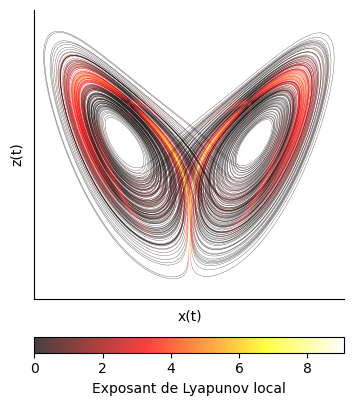

In [412]:
points = sol.y[::2].T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(λ_local.min(), λ_local.max())
lc = LineCollection(segments, cmap="hot", norm=norm, alpha=0.75)

fig, ax = plt.subplots(1, 1, figsize=(4, 5))

lc.set_array(λ_local[:-1])
lc.set_linewidth(0.25)
line = ax.add_collection(lc)
ax.set_xlim(-20, 20)
ax.set_ylim(0, 50)
fig.colorbar(line, ax=ax, label="Exposant de Lyapunov local", orientation="horizontal", pad=0.1)

#ax.set_aspect("equal")
ax.set(xticks=[], yticks=[])
ax.set_xlabel(r"x(t)")
ax.set_ylabel(r"z(t)")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.savefig("Lorenz_attractor_local_lyapunov_exponents.png", bbox_inches="tight", dpi=600)